# Clause Embedding and Semantic Search

## Step 1: Introduction and File Loading

This notebook focuses on transforming legal clause text into meaningful numerical representations using modern NLP embedding models. These embeddings enable powerful semantic search and similarity comparison across contract clauses.

We use transformer-based models such as **Sentence-BERT (SBERT)** — specifically, the **`msmarco-MiniLM-L6-cos-v5`** model — optimized for semantic similarity tasks. While it is not trained specifically on legal text, its fine-tuning on large-scale QA and IR datasets makes it highly effective for semantic clause retrieval.

### Objectives
- Load cleaned clause data from the preprocessing stage.
- Generate sentence embeddings for each clause using a search-optimized SBERT model.
- Perform basic clause similarity search using cosine similarity.
- Visualize top semantic matches to validate embedding quality.

> **Input File:** `results/cuad_normalized_clauses.csv`  
> **Output Files:**  
> - `results/clause_embeddings.npy`  
> - `results/clause_metadata.pkl`


In [1]:
from pathlib import Path
import pandas as pd

# — Determine project root & normalized CSV path —
BASE_DIR = Path.cwd().parent
NORMALIZED_CSV = BASE_DIR / "results" / "cuad_normalized_clauses.csv"

# — Fail fast if the normalized CSV isn’t found —
if not NORMALIZED_CSV.exists():
    raise FileNotFoundError(
        f"Normalized clauses CSV not found at {NORMALIZED_CSV.resolve()}"
    )

# — Load the normalized clauses DataFrame —
df_clauses = pd.read_csv(NORMALIZED_CSV, encoding="utf-8", on_bad_lines="warn")
print(f"Loaded normalized clauses from: {NORMALIZED_CSV.resolve()}")
print(f"Total clauses: {len(df_clauses)}")
print(f"Columns: {df_clauses.columns.tolist()}")

# — Sanity check: Required columns —
required_cols = {'clause_text', 'cleaned_type'}
missing_cols = required_cols - set(df_clauses.columns)
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")


Loaded normalized clauses from: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\cuad_normalized_clauses.csv
Total clauses: 13809
Columns: ['clause_text', 'clause_type', 'context', 'cleaned_type']


## Step 2: Load Sentence-BERT Embedding Model

To embed each legal clause into a semantic vector space, we use the `sentence-transformers` library.

For this project, we use **`msmarco-MiniLM-L6-cos-v5`**, a lightweight Sentence-BERT model fine-tuned specifically for **semantic similarity and retrieval** tasks using cosine similarity. While not legal-domain-specific, it is known to perform well in general-purpose semantic search scenarios and is widely adopted for fast, high-quality retrieval.

### Why This Model?

- Fine-tuned for **semantic search and QA** on large-scale datasets  
- Optimized for **cosine similarity** in dense vector space  
- **Lightweight and fast**, enabling quick experimentation on CPU or GPU  
- Compatible with `sentence-transformers`, enabling efficient inference and batching

This makes `msmarco-MiniLM-L6-cos-v5` an excellent baseline model for evaluating semantic clause similarity.


In [2]:
import torch
from sentence_transformers import SentenceTransformer

# — Determine compute device —
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# General-purpose semantic search model
MODEL_NAME = "msmarco-MiniLM-L6-cos-v5"
model = SentenceTransformer(MODEL_NAME, device=device)
print(f"Loaded embedding model: {MODEL_NAME} on {device}")

# — Optional: GPU memory info for debugging —
if device == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")


Using device: cuda
Loaded embedding model: msmarco-MiniLM-L6-cos-v5 on cuda
CUDA Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 86.65 MB
Memory Cached: 104.00 MB


## Step 3: Generate Clause Embeddings

Each legal clause is converted into a dense vector using a pretrained transformer model (`msmarco-MiniLM-L6-cos-v5`). These embeddings allow us to measure semantic similarity between clauses using cosine distance.

### Model Used:
- `msmarco-MiniLM-L6-cos-v5` (fine-tuned for semantic search and retrieval)

### Embedding Workflow:
1. **Input Preparation**  
   Extract the `clause_text` column from the cleaned dataset (`df_clauses`).

2. **Batch Processing**  
   Process clauses in batches of size `64` to avoid out-of-memory (OOM) errors.  
   Embedding is done via `model.encode(..., convert_to_tensor=True)` using GPU if available.

3. **Concatenation & Saving**  
   All batch embeddings are stacked into a single NumPy array and saved as:  
   `results/clause_embeddings.npy`

### Notes:
- **Search-optimized embeddings** capture semantic similarity well for clause retrieval  
- **Batch Size = 64**: Balanced for speed and memory usage (adjustable)  
- **GPU-Accelerated**: If CUDA is available, embeddings are computed on the GPU and transferred to CPU before saving

> This step produces a compact and reusable embedding matrix using a top-tier semantic search model — enabling high-quality clause retrieval.


In [3]:
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import time

# — Parameters —
BATCH_SIZE = 64
EMBEDDING_PATH = BASE_DIR / "results" / "clause_embeddings.npy"

# — Prepare texts —
texts = df_clauses["clause_text"].tolist()
n_texts = len(texts)
print(f"Generating embeddings for {n_texts} clauses in batches of {BATCH_SIZE}...")

# — Encode in batches using GPU —
all_embeddings = []
start_time = time.time()
for i in tqdm(range(0, n_texts, BATCH_SIZE), desc="Embedding batches"):
    batch = texts[i : i + BATCH_SIZE]
    embs = model.encode(
        batch,
        batch_size=BATCH_SIZE,
        show_progress_bar=False,
        convert_to_tensor=True,
        device=device
    ).cpu().numpy()
    all_embeddings.append(embs)
elapsed = time.time() - start_time

# — Save —
embeddings_array = np.vstack(all_embeddings)
EMBEDDING_PATH.parent.mkdir(exist_ok=True)
np.save(EMBEDDING_PATH, embeddings_array)

print(f"Saved embeddings to: {EMBEDDING_PATH.resolve()}")
print(f"Embeddings shape: {embeddings_array.shape}  –  Time elapsed: {elapsed:.1f}s")


Generating embeddings for 13809 clauses in batches of 64...


Embedding batches:   0%|          | 0/216 [00:00<?, ?it/s]

Saved embeddings to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\clause_embeddings.npy
Embeddings shape: (13809, 384)  –  Time elapsed: 17.3s


## Step 4: Build & Persist a Cosine-Similarity Index

To enable fast semantic clause search, we build a nearest-neighbor index over the `msmarco-MiniLM-L6-cos-v5` clause embeddings using **cosine similarity**.

The embeddings are normalized to unit vectors to ensure cosine distance reflects true semantic similarity — a critical step for search performance.

### Workflow:
1. **Load** clause embeddings from disk.
2. **Normalize** the embeddings using L2 norm.
3. **Fit** a `NearestNeighbors` index using cosine metric (from scikit-learn).
4. **Save**:
   - Trained NearestNeighbors model → `clause_nn_model.pkl`
   - Clause metadata (text, types, context) → `clause_metadata.pkl`

These saved artifacts power the real-time semantic retrieval via the `semantic_search_df()` function.

### Output Files:
- `results/clause_nn_model.pkl` → trained k-NN model  
- `results/clause_metadata.pkl` → clause metadata (for inspection and UI display)

> **SBERT embeddings + cosine k-NN indexing** form the foundation of an effective semantic clause search engine.


In [4]:
import numpy as np
import pickle
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# Paths
RESULTS_DIR     = BASE_DIR / "results"
EMBEDDING_PATH  = RESULTS_DIR / "clause_embeddings.npy"
NN_MODEL_PATH   = RESULTS_DIR / "clause_nn_model.pkl"
META_PATH       = RESULTS_DIR / "clause_metadata.pkl"
TOP_K           = 5  # can tune later

# 1) Load embeddings
embeddings = np.load(EMBEDDING_PATH)
if embeddings.shape[0] == 0:
    raise ValueError("No embeddings found — check if they were generated correctly.")
print(f"Loaded embeddings: {embeddings.shape}")

# 2) Normalize for cosine similarity
embeddings = normalize(embeddings, norm='l2')

# 3) Fit NearestNeighbors
nn = NearestNeighbors(n_neighbors=TOP_K, metric="cosine")
nn.fit(embeddings)
print("Fitted NearestNeighbors model on clause embeddings.")

# 4) Save model
with open(NN_MODEL_PATH, "wb") as f:
    pickle.dump(nn, f)
print(f"Saved NN model to: {NN_MODEL_PATH.resolve()}")

# 5) Save metadata
metadata = {
    "clause_text": df_clauses["clause_text"].tolist(),
    "cleaned_type": df_clauses["cleaned_type"].tolist() if "cleaned_type" in df_clauses else [],
    "context": df_clauses["context"].tolist() if "context" in df_clauses else [""] * len(df_clauses),
}
with open(META_PATH, "wb") as f:
    pickle.dump(metadata, f)
print(f"Saved metadata to: {META_PATH.resolve()}")


Loaded embeddings: (13809, 384)
Fitted NearestNeighbors model on clause embeddings.
Saved NN model to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\clause_nn_model.pkl
Saved metadata to: C:\Users\bestb\Desktop\MODELS\legal-clause-similarity-search\results\clause_metadata.pkl


## Step 5: Perform & Display Semantic Clause Search

In this step, we define `semantic_search_df()`, a reusable function that powers our legal clause retrieval engine using semantic similarity.

### What It Does:
1. **Embeds** the user's query using the same transformer model used for clause embeddings.
2. **Normalizes** the query vector to match cosine-based indexing.
3. **Searches** the prebuilt NearestNeighbors index for top-k relevant clauses.
4. **Returns** a formatted pandas `DataFrame` with semantic match scores and clause details.

This is the **core interface** of our clause search engine — enabling legal professionals to retrieve relevant contract clauses using **natural language**.

### Output Format:
- **Cosine Similarity Score** (between 0 and 1)
- **Clause Type** (e.g., “Confidentiality”, “Termination”)
- **Clause Text Preview** (truncated to ~100 characters)

### Usage Tip:
Try rephrasing your queries (e.g., "Termination clause", "Exit provisions") to explore semantic robustness.

> Powered by `msmarco-MiniLM-L6-cos-v5` embeddings + cosine k-NN search — optimized for legal clause retrieval.


In [5]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import normalize

# ------------------------
# Load Pretrained Artifacts
# ------------------------
RESULTS_DIR   = BASE_DIR / "results"
NN_MODEL_PATH = RESULTS_DIR / "clause_nn_model.pkl"
META_PATH     = RESULTS_DIR / "clause_metadata.pkl"

# Load NearestNeighbors model
with open(NN_MODEL_PATH, "rb") as f:
    nn = pickle.load(f)

# Load metadata: clause texts and types
with open(META_PATH, "rb") as f:
    metadata = pickle.load(f)

clause_texts = metadata["clause_text"]
labels       = metadata["cleaned_type"]
assert len(clause_texts) == len(labels), "Mismatch between clause texts and labels."

# ------------------------
# Semantic Search Function
# ------------------------
def semantic_search_df(query: str, top_k: int = 5, verbose: bool = False) -> pd.DataFrame:
    """
    Perform semantic clause search for a given legal query.
    
    Args:
        query (str): Natural language input (e.g., "Termination clause").
        top_k (int): Number of top results to return.
        verbose (bool): If True, print the matched clause types.

    Returns:
        pd.DataFrame: Top-k matched clauses with similarity scores.
    """
    # 1. Encode and normalize query
    q_emb = model.encode([query], convert_to_numpy=True)
    q_emb = normalize(q_emb)

    # 2. Retrieve top matches
    distances, indices = nn.kneighbors(q_emb, n_neighbors=top_k)
    sims = 1 - distances[0]

    # 3. Format results
    results = [{
        "score": float(score),
        "type": labels[idx],
        "clause": clause_texts[idx],
        "index": idx
    } for score, idx in zip(sims, indices[0])]

    df = pd.DataFrame(results).set_index("index")

    if verbose:
        print(f"\nQuery: {query}")
        print("Matched clause types:", df['type'].tolist())

    return df

# ------------------------
# Example Run
# ------------------------
query = "What are the clauses related to governing law of the contract?"
results_df = semantic_search_df(query, top_k=5, verbose=True)

# Format display
results_df.style.format({
    "score": "{:.4f}",
    "clause": lambda t: (t[:100] + "…") if len(t) > 100 else t
})



Query: What are the clauses related to governing law of the contract?
Matched clause types: ['governing law', 'governing law', 'governing law', 'governing law', 'governing law']


,score,type,clause
index,,,
4158,0.6131,governing law,this agreement shall be governed and construed and enforced in accordance with the laws of the state…
11584,0.6047,governing law,"this contract shall be governed by and construed in accordance with the laws of the state of texas, …"
8176,0.5794,governing law,the laws of the state of new york (without giving effect to its conflicts of law principles) govern …
13164,0.5767,governing law,"the validity, construction and enforceability of this agreement shall be governed by the laws of the…"
10772,0.5707,governing law,"the parties hereto have expressly agreed that this agreement shall be governed by, and construed in …"


## Step 6: Visualize Clause Embeddings with t-SNE

To visually assess the semantic structure of our clause embeddings, we use **t-SNE** (t-distributed Stochastic Neighbor Embedding) to reduce high-dimensional vectors to 2D. This qualitative technique reveals whether semantically similar clauses cluster together — an important sanity check for embedding quality.

### Why t-SNE?
- Helps identify **natural groupings** of clauses (e.g., "Confidentiality", "Termination").
- Reveals **label inconsistencies** or semantic overlaps (useful for refining training data).
- Visual inspection is a powerful tool for debugging and iterative model improvement.

### Visualization Workflow:
1. **Load** 384-dimensional embeddings from `msmarco-MiniLM-L6-cos-v5`.
2. **Clean & filter** clause type labels.
3. **Reduce dimensionality** using `TSNE` from `sklearn.manifold`.
4. **Highlight top 10 clause types** with distinct colors.

> This step provides a **qualitative validation** of how well the embedding model captures legal semantics.


Loaded embeddings shape: (13809, 384)
Running t-SNE dimensionality reduction...


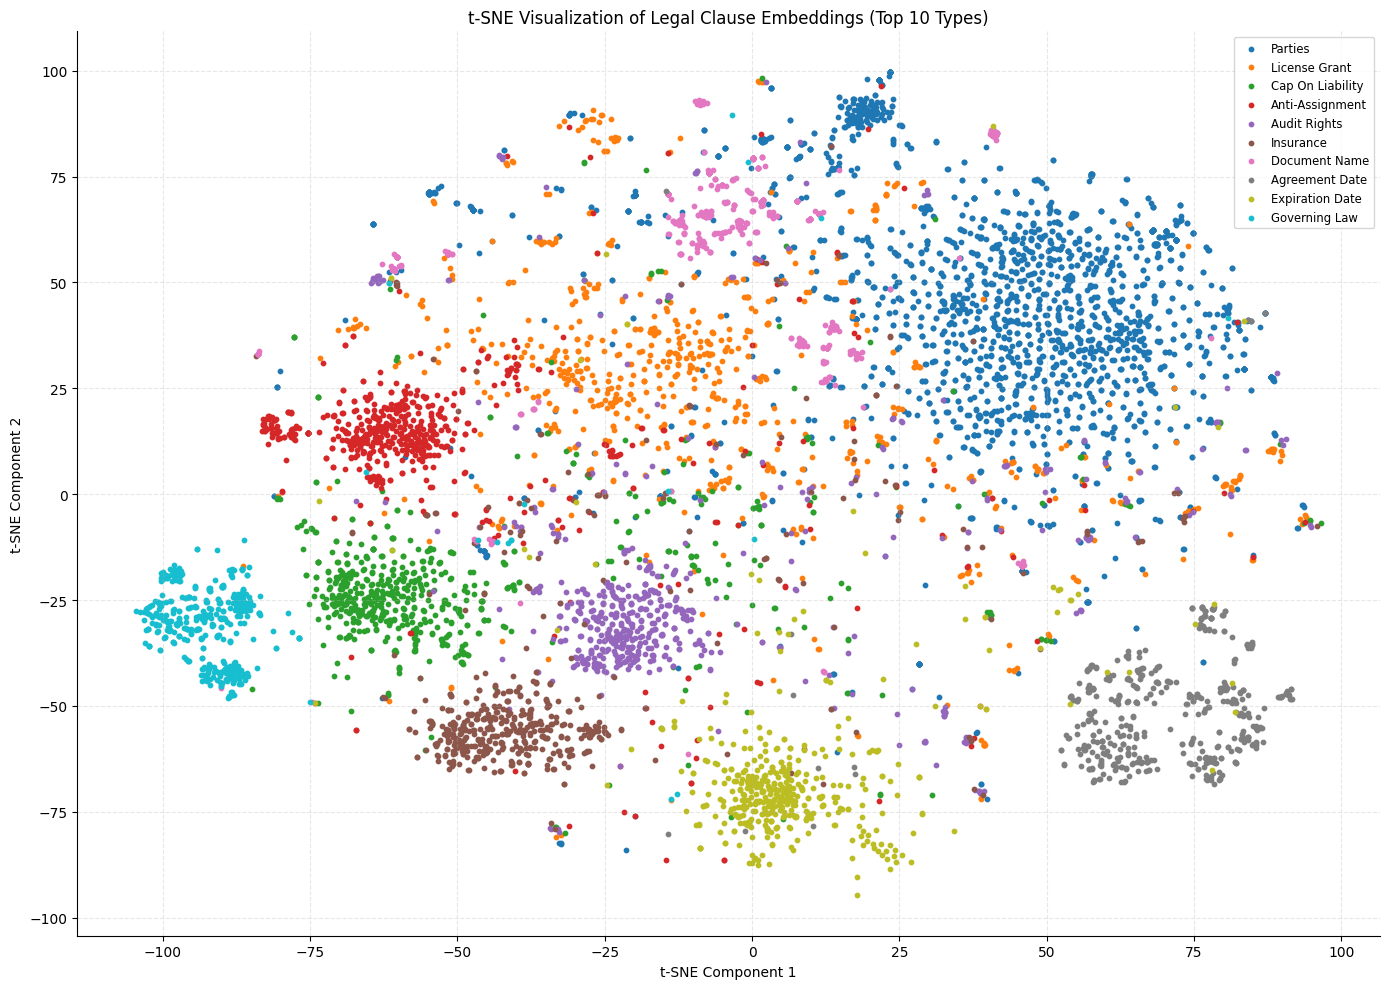

In [6]:
from pathlib import Path
import numpy as np
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# --------------------------
# Load Embeddings & Metadata
# --------------------------
RESULTS_DIR    = BASE_DIR / "results"
EMBEDDING_PATH = RESULTS_DIR / "clause_embeddings.npy"
META_PATH      = RESULTS_DIR / "clause_metadata.pkl"

# 1. Load clause embeddings
embeddings = np.load(EMBEDDING_PATH)
print(f"Loaded embeddings shape: {embeddings.shape}")

# 2. Load metadata (e.g., labels)
with open(META_PATH, "rb") as f:
    metadata = pickle.load(f)

clause_labels = metadata.get("cleaned_type", [])
clause_labels = [lbl.strip().lower().replace('"', '') for lbl in clause_labels][:len(embeddings)]

# --------------------------
# Dimensionality Reduction
# --------------------------
print("Running t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# --------------------------
# Prepare Coloring by Clause Type
# --------------------------
label_counts = Counter(clause_labels)
top_labels = [label for label, _ in label_counts.most_common(10)]
cmap = plt.get_cmap("tab10")
label_to_color = {label: cmap(i) for i, label in enumerate(top_labels)}
colors = [label_to_color.get(lbl, "lightgray") for lbl in clause_labels]

# --------------------------
# Plot t-SNE
# --------------------------
plt.figure(figsize=(14, 10))
for label in top_labels:
    idxs = [i for i, lbl in enumerate(clause_labels) if lbl == label]
    plt.scatter(
        embeddings_2d[idxs, 0], embeddings_2d[idxs, 1],
        label=label.title(), s=10
    )

plt.title("t-SNE Visualization of Legal Clause Embeddings (Top 10 Types)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="best", fontsize="small")
plt.tight_layout()
plt.show()


## Step 7: Example Semantic Clause Search

We now perform a **practical semantic search** using a realistic legal query. This acts as a **functional demonstration** of the retrieval pipeline and helps qualitatively validate the effectiveness of the semantic embeddings.

### Sample Query:
> “Termination of agreement”  
Also try: `"Termination clause"`, `"Exit provisions"`, `"Contract cancellation rules"`

### Search Logic:
The `semantic_search_df()` function:
1. **Embeds** the query using the same Sentence-BERT model (`msmarco-MiniLM-L6-cos-v5`) used for clause embeddings.
2. **Normalizes** the query vector for cosine similarity.
3. **Retrieves top-5 similar clauses** via a NearestNeighbors index.
4. **Displays clause types**, cosine similarity scores, and clause text.

### What We Learn:
- Whether semantically similar clauses are retrieved (even with reworded queries).
- If retrieved clause types match expectations.
- A quick sanity check before moving to formal evaluation.

> This is a **qualitative inspection step**. If top results are semantically relevant, it validates that our embedding and retrieval pipeline is working as intended.


In [ ]:
# — Define a legal-domain query —
query = "Termination of agreement"  # Alternatives: "Exit provisions", "Termination clause", etc.

# — Run semantic search —
results_df = semantic_search_df(query, top_k=5)

# — Clean type labels (for formatting consistency) —
results_df['type'] = results_df['type'].str.strip().str.replace('"', '')

# — Console output: Score + Clause Type —
print(f"\nQuery: {query}")
print("Top Clause Types + Cosine Scores:")
print(results_df[['type', 'score']])

# — Console output: Full top match —
print("\nFull Text of Top Clause:")
print(results_df.iloc[0]['clause'])

# — Display as styled table in notebook —
results_df.style.format({
    "score": "{:.4f}",
    "clause": lambda t: (t[:100] + "…") if len(t) > 100 else t
})



Query: Termination of agreement
Top Clause Types + Cosine Scores:
                            type     score
index                                     
8819   post-termination services  0.896646
2006   post-termination services  0.797648
10478          change of control  0.793490
13434          change of control  0.773479
8983               document name  0.771150

Full Text of Top Clause:
upon termination of this agreement,


,score,type,clause
index,,,
8819,0.8966,post-termination services,"upon termination of this agreement,"
2006,0.7976,post-termination services,upon the termination of this agreement by either party:
10478,0.7935,change of control,this agreement may be terminated:
13434,0.7735,change of control,this agreement may be terminated only:
8983,0.7712,document name,mutual termination agreement


: 

# Notebook Summary

This notebook demonstrates an end-to-end pipeline for building a **semantic clause search engine** using transformer-based sentence embeddings.

We:

1. **Loaded** the normalized CUAD clause dataset (`cuad_normalized_clauses.csv`).
2. **Initialized** a powerful semantic search model (`msmarco-MiniLM-L6-cos-v5`) from the Sentence-Transformers library.
3. **Encoded** over 13,000 legal clauses into dense vector embeddings in memory-efficient batches.
4. **Built** a cosine similarity-based index using `NearestNeighbors` to support fast and scalable retrieval.
5. **Packaged** a reusable `semantic_search_df()` function for querying clauses by legal intent or natural language.
6. **Visualized** the embedding space using **t-SNE**, revealing clusters aligned with major clause types (e.g., "Confidentiality", "Termination").
7. **Tested** the system with real-world queries (e.g., “termination of agreement”), demonstrating the practical semantic relevance of top results.

> This pipeline enables **meaning-based clause search** — a major improvement over traditional keyword-based systems — and forms the foundation of intelligent legal document understanding.
